Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


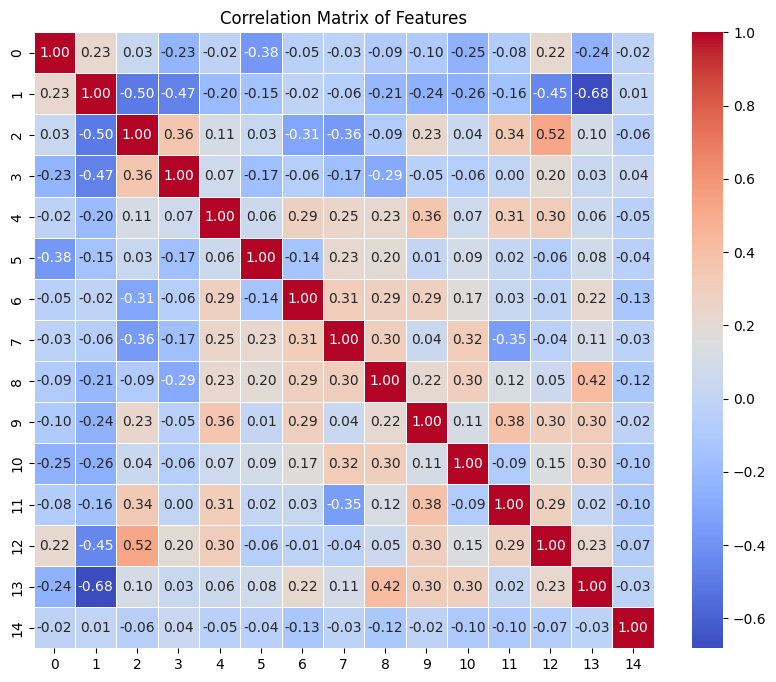

Number of components explaining at least 95% of the variance: 12
SVM Cross-Validation Accuracy (Original Features): [0.9        0.95333333 0.90666667 0.96333333 0.93333333]
Random Forest Cross-Validation Accuracy (Original Features): [0.83333333 0.93666667 0.80666667 0.93333333 0.90666667]
SVM Cross-Validation Accuracy (PCA Features): [0.9        0.94666667 0.87666667 0.94666667 0.90333333]
Random Forest Cross-Validation Accuracy (PCA Features): [0.84666667 0.91666667 0.84333333 0.9        0.89666667]


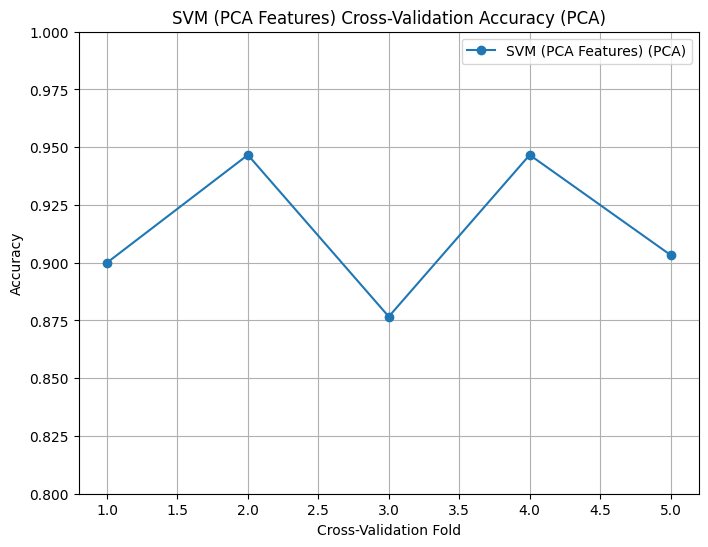

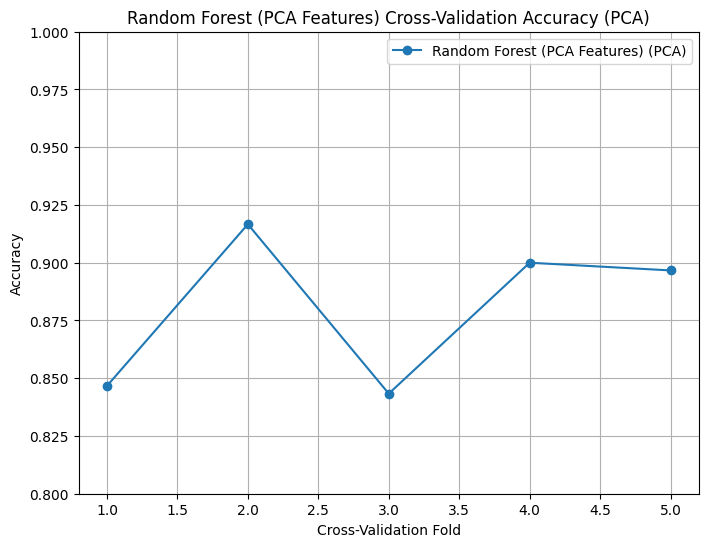

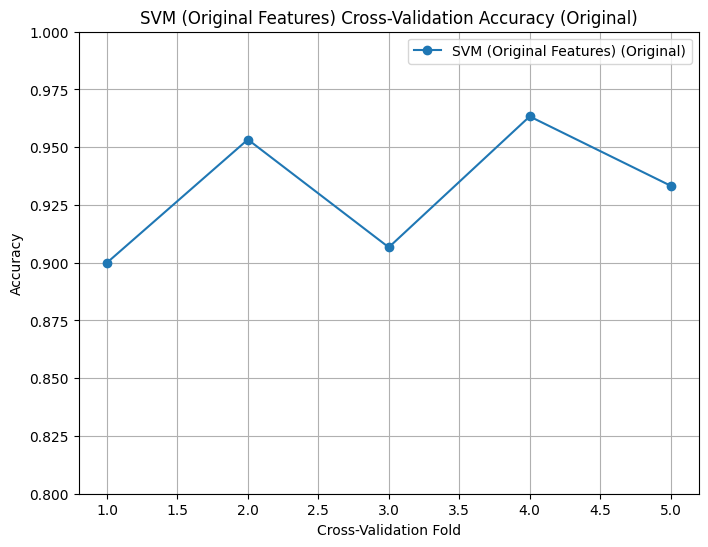

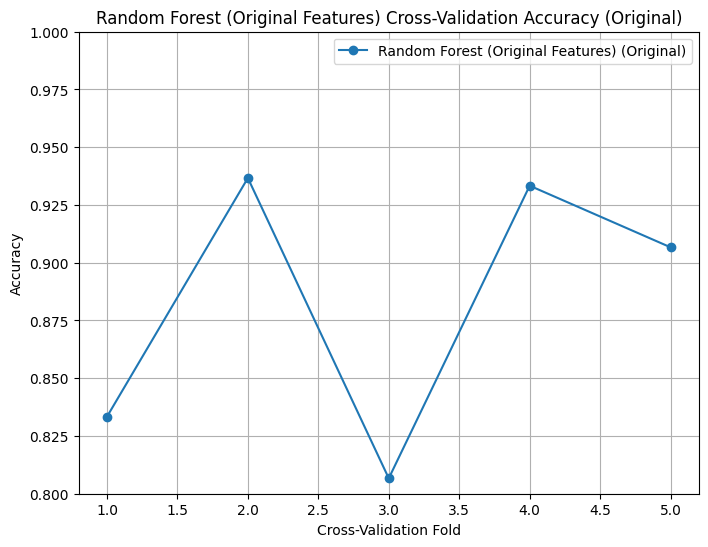

In [7]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon

# Load FSDD dataset paths from Google Drive
from google.colab import drive
drive.mount('/content/drive')
fsdd_path = '/content/drive/My Drive/recordings'

# Lists to store features and labels
features = []
labels = []

# Iterate over each audio file in FSDD
for filename in os.listdir(fsdd_path):
    if filename.endswith('.wav'):
        # Load the audio file
        filepath = os.path.join(fsdd_path, filename)
        audio, sr = librosa.load(filepath, sr=None)

        # Extract features (MFCCs)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=512)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # Zero Crossing Rate (ZCR)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio, hop_length=512))

        # Fundamental Frequency (F0) and Jitter
        f0, _, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
        f0_valid = f0[~np.isnan(f0)]
        jitter = np.std(np.diff(f0_valid)) if f0_valid.size > 1 else 0

        # Combine MFCCs with ZCR and Jitter
        feature_vector = np.concatenate([mfccs_mean, [zcr, jitter]])

        # Features and label
        features.append(feature_vector)

        # Digit labels from the filename
        label = int(filename.split('_')[0])
        labels.append(label)

# Convert to DataFrame
df = pd.DataFrame(features)
df['target'] = labels

# Correlation test / correlation matrix
correlation_matrix = df.drop(columns='target').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Prepare data for PCA/Normalize the dataset before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns='target'))

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
# Print the number of components used
print(f"Number of components explaining at least 95% of the variance: {pca.n_components_}")

# Define feature matrix X and target vector y
X_orig = X_scaled
X_pca = pd.DataFrame(X_pca)
y = df["target"]

# Define models
svc = SVC()
rf = RandomForestClassifier()

# Define parameter grids for Grid Search
svc_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}

# Perform cross-validation and Grid Search for PCA-transformed features
svc_grid_pca = GridSearchCV(svc, svc_param_grid, scoring='f1_macro', cv=5)
svc_grid_pca.fit(X_pca, y)
rf_grid_pca = GridSearchCV(rf, rf_param_grid, scoring='f1_macro', cv=5)
rf_grid_pca.fit(X_pca, y)

best_svc_pca = svc_grid_pca.best_estimator_
best_rf_pca = rf_grid_pca.best_estimator_

svc_cv_scores_pca = cross_val_score(best_svc_pca, X_pca, y, cv=5, scoring='accuracy')
rf_cv_scores_pca = cross_val_score(best_rf_pca, X_pca, y, cv=5, scoring='accuracy')

# Perform cross-validation and Grid Search for original features
svc_grid_orig = GridSearchCV(svc, svc_param_grid, scoring='f1_macro', cv=5)
svc_grid_orig.fit(X_orig, y)
rf_grid_orig = GridSearchCV(rf, rf_param_grid, scoring='f1_macro', cv=5)
rf_grid_orig.fit(X_orig, y)

best_svc_orig = svc_grid_orig.best_estimator_
best_rf_orig = rf_grid_orig.best_estimator_

svc_cv_scores_orig = cross_val_score(best_svc_orig, X_orig, y, cv=5, scoring='accuracy')
rf_cv_scores_orig = cross_val_score(best_rf_orig, X_orig, y, cv=5, scoring='accuracy')

print("SVM Cross-Validation Accuracy (Original Features):", svc_cv_scores_orig)
print("Random Forest Cross-Validation Accuracy (Original Features):", rf_cv_scores_orig)
print("SVM Cross-Validation Accuracy (PCA Features):", svc_cv_scores_pca)
print("Random Forest Cross-Validation Accuracy (PCA Features):", rf_cv_scores_pca)

# Plot cross-validation accuracy
def plot_cross_val_accuracy(cv_scores, model_name, features_type):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', label=f'{model_name} ({features_type})')
    plt.ylim(0.8, 1.0)
    plt.xlabel("Cross-Validation Fold")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Cross-Validation Accuracy ({features_type})")
    plt.legend()
    plt.grid()
    plt.show()


# Plot cross-validation scores
svc_scores_pca_plot = plot_cross_val_accuracy(svc_cv_scores_pca, "SVM (PCA Features)", "PCA")
rf_scores_pca_plot = plot_cross_val_accuracy(rf_cv_scores_pca, "Random Forest (PCA Features)", "PCA")
svc_scores_orig_plot = plot_cross_val_accuracy(svc_cv_scores_orig, "SVM (Original Features)", "Original")
rf_scores_orig_plot = plot_cross_val_accuracy(rf_cv_scores_orig, "Random Forest (Original Features)", "Original")
